In [1]:
import pandas as pd
import numpy as np
import json
from yahoo_oauth import OAuth2

### Load OAUTH

In [2]:
oauth = OAuth2(None, None, from_file='oauth.json')
if not oauth.token_is_valid():
    oauth.refresh_access_token()
oauth.oauth.base_url='https://fantasysports.yahooapis.com/fantasy/v2/'

oauth.refresh_access_token()

[2019-10-19 20:53:28,299 DEBUG] [yahoo_oauth.yahoo_oauth.__init__] Checking 
[2019-10-19 20:53:28,308 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] ELAPSED TIME : 3894612.89255023
[2019-10-19 20:53:28,309 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] TOKEN HAS EXPIRED
[2019-10-19 20:53:28,310 DEBUG] [yahoo_oauth.yahoo_oauth.refresh_access_token] REFRESHING TOKEN
[2019-10-19 20:53:28,514 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] ELAPSED TIME : 0.20345401763916016
[2019-10-19 20:53:28,515 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] TOKEN IS STILL VALID
[2019-10-19 20:53:28,516 DEBUG] [yahoo_oauth.yahoo_oauth.refresh_access_token] REFRESHING TOKEN


{'token_time': 1571532808.5168471,
 'access_token': 'reM4lYKRoljfvbF1lNJqumtJ_.nuQ23vMfmdxVStkBR1eLurkMcZ0lDUT92Jmf_h2DhQLvmPLgLAHii6PoIBngAkdKj3KOBXaknKT0RG1O1nNeDzsK3q_SRywnLv5WWO_9nNtBlo2lcri4WtsoRRV8hzOlkFoU0mKViYhLNvMvIhcfHrvR7tWIjPcuv.6._KLPJ16reWPiZra3mQKRjNCQ_k7QshIHURRuhuLEG3b2F3U3gtmSyTtb6P9x4HMlWaU919T6D_MD9GeDGVs.UWyeExCRNblO.hwOwYlsSVN.vzQhvnSWWfEo6w2Y9m6AGmhvFzobgLP9h1lzCs9JgoS.SDlbNBnpsbTlJkftgbTWvzDiqh_XuZGbD4PY7GEzEugXu3CcMtRY5ubB9ZHcUajen0MU9v6NfOp.c0YxqEBVsHzF05lMvYkT6hh3EyyKMivU4kvTq1UN3wdAkMeNxwnvcJ_Z8UQk0JHmUJJf.t6ExfVsHj8PJ83apmf1ZsVcuvrDke5mr2D7zt_OLmo2P8kutUXGBw0yju6tkJY0Hg0CStfIin_rqCPerOVbGmSBPbyi5KwuMfoZyMpA.3l24x4wQ0R0KnP7aMvkGSq1FHk1NgffiXBC.dH6kDU9C.9vEeDmM24f6DsLWFfdj6BFNLILcAzu02AaPEGkZQRo2bpZy3JyKIl6n9nYkncb1F3vZTHonM0tiDfVmW37nwosGXs7ktQBzOAodwQtYMLsc9EgmI4FiDBTcHjf9yMP8JUO9xb4oITPZbmkCbOcbHbI5GPCXIMEZTWNJSRswfu6jBE4M.MCQ1zvZ1tA_LQA77KgpDJojKYhqvasRciShtuDGJiMItx7OFB0TOmdvJ6Hye9E8GKRc88Di6GA4NiosH3ZKukcmN5R5Qhm3nbqA5UVQuoh1d6f70kNwAT0kjZ286szV66PUGQGZ

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [4]:
from fantasy_sport import FantasySport
yfs = FantasySport(oauth, fmt='json')

In [6]:
[x['game'][0] for x in json.loads(oauth.session.get('games;seasons=2019', params={'format': 'json'}).content)['fantasy_content']['games'].values() if isinstance(x,dict) and isinstance(x['game'], list) and x['game'][0]['name']=='Basketball']
#json.loads(oauth.session.get('users;use_login=1/games;game_keys=nfl/leagues', params={'format': 'json'}).content)

[{'game_key': '395',
  'game_id': '395',
  'name': 'Basketball',
  'code': 'nba',
  'type': 'full',
  'url': 'https://basketball.fantasysports.yahoo.com/nba',
  'season': '2019',
  'is_registration_over': 0,
  'is_game_over': 0,
  'is_offseason': 0,
  'is_live_draft_lobby_active': 1}]

In [7]:
#%%
#response = json.loads(yfs.get_leagues_teams(['353.l.38761']).content)
league_string = '395.l.42451' #2020 pragma
ffl_dir = 'D:/workspace/yahoo-ffl'

### Load Team Data

In [8]:
#%%
response = json.loads(oauth.session.get('league/'+league_string+'/teams', params={'format':'json'}).content)
teamnames = [x['team'][0][2]['name'] for k,x in response['fantasy_content']['league'][1]['teams'].items() if k not in ['count']]
teamkeys = [x['team'][0][0]['team_key'] for k,x in response['fantasy_content']['league'][1]['teams'].items() if k not in ['count']]

#### Load Player Data

In [9]:
#%%

playersByKey = {} 
for start in range(1,2000,25):
    response = json.loads(oauth.session.get('leagues;league_keys='+league_string+'/players;start='+str(start)+"/stats", params={'format':'json'}).content)
    players = response['fantasy_content']['leagues']['0']['league'][1]['players']
    if(not players):
        break
    playersByKey.update({x['player'][0][0]['player_key']:{next(iter(d.keys())):next(iter(d.values())) for d in x['player'][0] if isinstance(d, dict)} for k,x in players.items() if k not in ['count']})

In [11]:
#%%
playerFrame = pd.DataFrame.from_dict(playersByKey, orient='index')
playerFrame['name'] = playerFrame.apply(lambda x:x['name']['full'], axis=1)
playerFrame['eligible_positions'] = playerFrame.apply(lambda x:[str(next(iter(d.values()))) for d in x['eligible_positions']], axis=1)
#playerFrame['bye_weeks'] = playerFrame.apply(lambda x:next(iter(x['bye_weeks'].values())), axis=1)

In [12]:
playerFrame[playerFrame.name.str.match(".*Davis.*")]

,player_key,player_id,name,status,editorial_player_key,editorial_team_key,editorial_team_full_name,editorial_team_abbr,uniform_number,display_position,headshot,is_undroppable,position_type,primary_position,eligible_positions,has_player_notes,has_recent_player_notes,player_notes_last_timestamp
395.p.4728,395.p.4728,4728,Ed Davis,NaN,nba.p.4728,nba.t.26,Utah Jazz,Uta,17,"PF,C",{'url': 'https://s.yimg.com/iu/api/res/1.2/iPL...,0,P,PF,"[PF, F, C, Util]",1.0,NaN,1.570676e+09
395.p.4926,395.p.4926,4926,Davis Bertans,NaN,nba.p.4926,nba.t.27,Washington Wizards,Was,42,"PF,C",{'url': 'https://s.yimg.com/iu/api/res/1.2/fwY...,0,P,PF,"[PF, F, C, Util]",1.0,1.0,1.571449e+09
395.p.5007,395.p.5007,5007,Anthony Davis,NaN,nba.p.5007,nba.t.13,Los Angeles Lakers,LAL,3,"PF,C",{'url': 'https://s.yimg.com/iu/api/res/1.2/EvA...,0,P,PF,"[PF, F, C, Util]",1.0,NaN,1.571344e+09
395.p.5662,395.p.5662,5662,Deyonta Davis,NA,nba.p.5662,nba.t.1,Atlanta Hawks,Atl,4,PF,{'url': 'https://s.yimg.com/iu/api/res/1.2/H_9...,0,P,PF,"[PF, F, Util]",NaN,NaN,NaN
395.p.6095,395.p.6095,6095,Tyler Davis,NA,nba.p.6095,nba.t.25,Oklahoma City Thunder,OKC,34,C,{'url': 'https://s.yimg.com/iu/api/res/1.2/_D_...,0,P,C,"[C, Util]",NaN,NaN,NaN
395.p.6142,395.p.6142,6142,Devin Davis,NA,nba.p.6142,nba.t.19,Orlando Magic,Orl,61,SF,{'url': 'https://s.yimg.com/iu/api/res/1.2/TcM...,0,P,SF,"[SF, F, Util]",NaN,NaN,NaN
395.p.6280,395.p.6280,6280,Terence Davis,NaN,nba.p.6280,nba.t.28,Toronto Raptors,Tor,0,SG,{'url': 'https://s.yimg.com/iu/api/res/1.2/WuV...,0,P,SG,"[SG, G, Util]",1.0,NaN,1.571013e+09
395.p.6338,395.p.6338,6338,Jon Davis,NaN,nba.p.6338,nba.t.19,Orlando Magic,Orl,73,PG,{'url': 'https://s.yimg.com/iu/api/res/1.2/TcM...,0,P,PG,"[PG, G, Util]",NaN,NaN,NaN


### Load Player Stats

In [708]:
#%%
playerStats = pd.concat ([pd.read_csv(ffl_dir + "/stats.csv").assign(year=2020)
#pd.read_csv(ffl_dir + "/stats-2019.csv").assign(year=2019)
#pd.read_csv(ffl_dir + "/stats-2017.csv").assign(year=2017)
                         ],sort=False)
#playerStats['pos'] = playerStats['position'].apply(lambda x:x[x.find(' - ')+3:] if x.find(' - ') >0 else x)
playerStats['pos'] = playerStats['position']
#playerStats['avgPts'] = playerStats['points']/playerStats['games']

### Load League Settings

In [709]:
#%%
#json.loads(yfs._get('leagues;league_keys='+league_string+'/players;count=1').content)['fantasy_content']['leagues']['0']['league']

league_settings = json.loads(oauth.session.get('leagues;league_keys='+league_string+'/settings', params={'format': 'json'}).content)['fantasy_content']['leagues']['0']['league'][1]['settings'][0]
roster_positions = pd.DataFrame([x['roster_position'] for x in league_settings['roster_positions']])
stat_settings = pd.DataFrame([x['stat'] for x in league_settings['stat_categories']['stats']])
stat_settings = pd.merge(stat_settings, pd.DataFrame([x['stat'] for x in league_settings['stat_modifiers']['stats']]), on='stat_id')
team_count = int(league_settings['max_teams'])

In [710]:
roster_positions = roster_positions.assign(repl_rank=roster_positions['count']*team_count)
#roster_positions = roster_positions.set_index('position')
roster_positions

,count,position,position_type,repl_rank
0,1,QB,O,12
1,3,WR,O,36
2,2,RB,O,24
3,1,TE,O,12
4,1,W/R/T,O,12
5,1,K,K,12
6,1,DEF,DT,12
7,5,BN,NaN,60


In [711]:
stat_map = {
    'passing_yds':'Pass Yds',
    'passing_tds':'Pass TD',
    'passing_int':'Int',
    'rushing_yds':'Rush Yds',
    'rushing_tds':'Rush TD',
    'receiving_rec':'Rec',
    'receiving_yds':'Rec Yds',
    'receiving_tds':'Rec TD',
    'fumbles':'Fum Lost'
}

In [712]:
playerStats.rename(index=str, columns=stat_map)[list(stat_map.values())].iloc[0]

Pass Yds    304.0
Pass TD       2.6
Int           0.9
Rush Yds     18.3
Rush TD       0.1
Rec           0.0
Rec Yds       0.0
Rec TD        0.0
Fum Lost      0.2
Name: 0, dtype: float64

In [713]:
stat_multiplier = pd.to_numeric(stat_settings.loc[stat_settings.position_type=='O'].set_index('display_name').value.loc[list(stat_map.values())])

In [714]:
stat_multiplier

display_name
Pass Yds    0.04
Pass TD     4.00
Int        -2.00
Rush Yds    0.10
Rush TD     6.00
Rec         1.00
Rec Yds     0.10
Rec TD      6.00
Fum Lost   -2.00
Name: value, dtype: float64

In [715]:
playerStats['points_real'] = playerStats.points #playerStats.rename(index=str, columns=stat_map)[list(stat_map.values())].dot(stat_multiplier).reset_index(drop=True)

### Calculate Mean Stats

In [716]:
stats_mean = playerStats.groupby(['name','pos']).points_real.agg({'points_real':'mean','count':'count'}).reset_index()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [717]:
stats_mean = stats_mean[stats_mean['count']>5]

# Update Draft Results

In [873]:
#%%
response = json.loads(yfs._get('leagues;league_keys='+league_string+'/draftresults').content)
draftresults = response['fantasy_content']['leagues']['0']['league'][1]['draft_results']
if draftresults:
    draftresults = pd.DataFrame([x['draft_result'] for k,x in draftresults.items() if k not in ['count'] and 'player_key' in x['draft_result']])
    draftresults = draftresults.assign(name=playerFrame.loc[draftresults.player_key].name.reset_index(drop=True))
    draftresults = draftresults.assign(pos=playerFrame.loc[draftresults.player_key].display_position.reset_index(drop=True))
    draft_counts = draftresults.groupby(['team_key','pos']).agg('size').rename('count').reset_index().assign(pos_limit = lambda x:x.pos.map(roster_positions.set_index('position')['count'])).assign(pos_filled = lambda x:x[['count', 'pos_limit']].min(axis=1))

[2019-09-04 19:50:17,347 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] ELAPSED TIME : 2821.7023282051086
[2019-09-04 19:50:17,347 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] TOKEN IS STILL VALID


### Calc replacement values

In [874]:
rep_rank_map = roster_positions.set_index('position').repl_rank.to_dict()
replacement={}
replacement['QB'] = stats_mean.loc[stats_mean.pos=='QB'].sort_values('points_real', ascending=False).reset_index(drop=True).iloc[rep_rank_map['QB']].points_real
#remaining players after filling position specific slots
wrt_players = stats_mean.loc[stats_mean.pos.isin(['WR', 'RB', 'TE'])].sort_values('points_real', ascending=False).reset_index(drop=True)
pos_players = wrt_players.iloc[rep_rank_map['W/R/T']:]

### Calc VORP

In [875]:
bench_players = []
for position in ['WR', 'RB', 'TE']:
    filtered_players = pos_players.loc[pos_players.pos==position].sort_values('points_real', ascending=False).reset_index(drop=True)
    rep_index = min(rep_rank_map[position], len(filtered_players.index)-1)
    bench_players.append(filtered_players.iloc[rep_index:])
    replacement[position] = filtered_players.iloc[rep_index].points_real
bench_players=pd.concat(bench_players)
#stats_mean['vorp'] = stats_mean.apply(lambda x:x.points_real-replacement[x.pos], axis=1)
stats_mean['vorp'] = stats_mean.points_real-stats_mean.pos.replace(replacement)

In [876]:
#replacement.update(wrt_players.iloc[rep_rank_map['W/R/T']+2:].groupby('pos').points_real.max().to_dict())
replacement

{'QB': 19.25923076923077,
 'WR': 11.02076923076923,
 'RB': 11.735384615384614,
 'TE': 9.598999999999998}

### Update values

In [877]:
#update vorp rank
stats_mean = stats_mean.assign(vorp_rank = lambda x: x.groupby('pos').vorp.transform(lambda x: x.rank(ascending=False)))

In [878]:
remaining_players = stats_mean if len(draftresults)==0 else stats_mean[~stats_mean.name.isin(list(draftresults.name))]
spent_val = 0 if len(draftresults)==0 else pd.to_numeric(draftresults.cost).sum()

In [879]:
#update vorp
vorp_val = (int(league_settings['max_teams']) * 200 - spent_val) / stats_mean[stats_mean.vorp>=0].vorp.sum()
stats_mean['val'] = stats_mean['vorp'] * vorp_val

### Plot Values

In [880]:
import bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.transform import factor_cmap

p = figure(tools=[bokeh.models.tools.HoverTool(
    tooltips=[
        ( 'name',   '@name'            ),
        ( 'vorp',  '@vorp' ), 
        ( 'points', '@points_real'      ),
        ( 'value', '@val'      ),
    ])
])
p.legend.location = "top_right"
p.scatter(x='vorp_rank', y='vorp', source=remaining_players, size=8, legend='pos', color=factor_cmap('pos', palette=bokeh.palettes.Spectral4, factors=remaining_players.pos.unique()))
output_notebook()
show(p)

Loading BokehJS ...

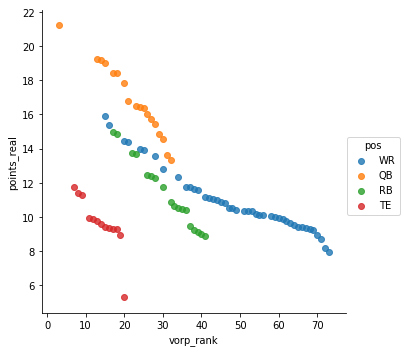

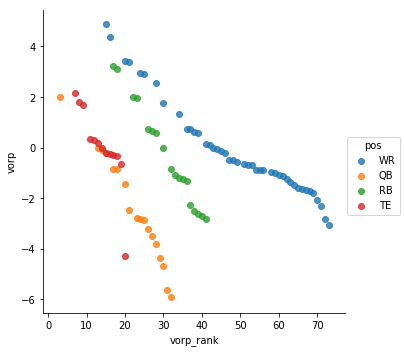

In [881]:
import seaborn as sns
sns.lmplot(x='vorp_rank', y="points_real", data=remaining_players, fit_reg=False, hue='pos', legend=True)
sns.lmplot(x='vorp_rank', y="vorp", data=remaining_players, fit_reg=False, hue='pos', legend=True)

In [882]:
stats_mean.loc[stats_mean.name.str.contains('Ryan')]

,name,pos,points_real,count,vorp,vorp_rank,val
133,Matt Ryan,QB,19.793077,13,0.533846,9.0,0.479071
165,Ryan Fitzpatrick,QB,16.021538,13,-3.237692,26.0,-2.905491


In [883]:
remaining_players[remaining_players.pos.apply(lambda x: x in (['TE','WR','RB','QB']))].sort_values('vorp', ascending=False).reset_index()

,index,name,pos,points_real,count,vorp,vorp_rank,val
0,0,A.J. Green,WR,15.917000,10,4.896231,15.0,4.909960
1,139,Mike Williams,WR,15.397692,13,4.376923,16.0,4.389196
2,184,Tyler Boyd,WR,14.424615,13,3.403846,20.0,3.413390
3,110,Kenny Golladay,WR,14.398462,13,3.377692,21.0,3.387163
4,65,Duke Johnson Jr.,RB,14.970833,12,3.235449,17.0,3.244521
5,154,Phillip Lindsay,RB,14.828462,13,3.093077,18.0,3.101750
6,34,D.J. Moore,WR,13.972500,12,2.951731,24.0,2.960007
7,171,Sterling Shepard,WR,13.908462,13,2.887692,25.0,2.895789
8,167,Sammy Watkins,WR,13.581538,13,2.560769,28.0,2.567949
9,188,Vance McDonald,TE,11.770000,13,2.171000,7.0,2.177087


In [872]:
wrt_players.sort_values('points_real', ascending=False)

,name,pos,points_real,count,vorp,vorp_rank,val
0,Saquon Barkley,RB,24.686923,13,12.951538,1.0,16.751380
1,Ezekiel Elliott,RB,23.192500,12,11.457115,2.0,14.818509
2,Alvin Kamara,RB,22.001538,13,10.266154,3.0,13.278132
3,Christian McCaffrey,RB,20.167692,13,8.432308,4.0,10.906256
4,Julio Jones,WR,19.802308,13,8.781538,1.0,11.357947
5,Davante Adams,WR,19.593846,13,8.573077,2.0,11.088325
6,Michael Thomas,WR,19.508462,13,8.487692,3.0,10.977889
7,DeAndre Hopkins,WR,19.479231,13,8.458462,4.0,10.940083
8,JuJu Smith-Schuster,WR,19.247692,13,8.226923,5.0,10.640613
9,Melvin Gordon III,RB,19.203333,12,7.467949,5.0,9.658964


In [836]:
#%%
response = json.loads(yfs.get_teams_roster(teamkeys).content)
teams = {team['team'][0][2]['name']:[player['player'][0][2]['name']['full'] 
              for p,player in team['team'][1]['roster']['0']['players'].items() if p not in ['count']] 
              for t,team in response['fantasy_content']['teams'].items() if t not in ['count']}

[2019-09-04 19:27:41,610 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] ELAPSED TIME : 1465.9661028385162
[2019-09-04 19:27:41,611 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] TOKEN IS STILL VALID


AttributeError: 'list' object has no attribute 'items'